# Import Librarys and Models

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision

from PIL import Image
from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)

##################### Additional Import CLIP #######################
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

import clip
import torch.nn.functional as F
###############################################################

cuda
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vyl_1js0
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-vyl_1js0
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [2]:
imagenet_templates = [
    'a bad photo of a {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a tattoo of a {}.',
    'the embroidered {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'the plastic {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a plastic {}.',
    'a photo of the dirty {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a {} in a video game.',
    'a photo of one {}.',
    'a doodle of a {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'the origami {}.',
    'the {} in a video game.',
    'a sketch of a {}.',
    'a doodle of the {}.',
    'a origami {}.',
    'a low resolution photo of a {}.',
    'the toy {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a photo of a weird {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a sketch of the {}.',
    'a embroidered {}.',
    'a pixelated photo of a {}.',
    'itap of the {}.',
    'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.',
    'a plushie {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'the cartoon {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a black and white photo of a {}.',
    'the plushie {}.',
    'a dark photo of a {}.',
    'itap of a {}.',
    'graffiti of the {}.',
    'a toy {}.',
    'itap of my {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
    'a tattoo of the {}.',
]


In [3]:
vgg_model = torchvision.models.vgg19(weights = 'DEFAULT').features.to(device).eval()

In [4]:
clip_model, preprocess = clip.load('ViT-B/32', device, jit=False)

# Additional Functions

In [5]:
mean = torch.tensor([0.485, 0.456, 0.406])
std  = torch.tensor([0.229, 0.224, 0.225])
## pretrain vgg network (model)

clip_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
clip_std = torch.tensor([0.26862954, 0.26130258, 0.27577711])
## clip model

def load_img(image_path, image_shape = (512, 512), device = device):
  img = Image.open(image_path)
  transforms = torchvision.transforms.Compose([
      torchvision.transforms.Resize(image_shape),
      torchvision.transforms.ToTensor()]
  )
  return transforms(img).unsqueeze(0).to(device) # (1, 3, 512, 512)

def prepocessing(img, device = device):
  transforms = torchvision.transforms.Compose([
      torchvision.transforms.Normalize(mean = mean , std = std)
  ])

  return transforms(img).to(device)

def clip_normalize(image, image_shape = (224, 224), device = device):
    image = F.interpolate(image,size=224,mode='bicubic')
    transforms = torchvision.transforms.Compose([
      torchvision.transforms.Normalize(mean = clip_mean , std = clip_std)
    ])

    return transforms(image).to(device) # (1,3,224,224)


In [6]:
class NST_VGG(nn.Module):
  def __init__(self):
    super(NST_VGG, self).__init__()

    #self.styles_layers = [0, 5, 10, 19, 28]
    self.content_layers = [25] #[21, 31]

    self.model = vgg_model

  def forward(self, x):
    contents = []
    #styles = []

    for layer_num, layer in enumerate(self.model):
      x = layer(x)
      # if layer_num in self.styles_layers:
      #   styles.append(x)
      if layer_num in self.content_layers:
        contents.append(x)

    return contents

In [7]:
def content_loss(content, generated):
  return torch.square( content.detach() - generated ).mean()

def total_variation_loss(img):
  a = torch.abs(img[:,:, 1:, :] - img[:,:,:-1, :]).mean()
  b = torch.abs(img[:,:, :, 1:] - img[:,:,:, :-1]).mean()

  return (a + b ) / 2

def local_glob_loss(num_crops, target, source_features, text_features, text_source, threshold = 0.7):
  loss_local=0
  img_proc =[]
  for n in range(num_crops):
      target_crop = cropper(target)
      target_crop = augment(target_crop)
      img_proc.append(target_crop)

  img_proc = torch.cat(img_proc,dim=0)
  img_aug = img_proc

  image_features = clip_model.encode_image(clip_normalize(img_aug,device))
  image_features /= (image_features.clone().norm(dim=-1, keepdim=True))

  img_direction = (image_features-source_features)
  img_direction /= img_direction.clone().norm(dim=-1, keepdim=True)

  text_direction = (text_features-text_source).repeat(image_features.size(0),1)
  text_direction /= text_direction.norm(dim=-1, keepdim=True)

  loss_temp = (1- torch.cosine_similarity(img_direction, text_direction, dim=1))
  loss_temp[loss_temp < threshold] = 0
  loss_local+=loss_temp.mean()

  glob_features = clip_model.encode_image(clip_normalize(target,device))
  glob_features /= (glob_features.clone().norm(dim=-1, keepdim=True))

  glob_direction = (glob_features-source_features)
  glob_direction /= glob_direction.clone().norm(dim=-1, keepdim=True)

  loss_glob = (1- torch.cosine_similarity(glob_direction, text_direction, dim=1)).mean()

  return loss_local, loss_glob

def total_loss(content_y_hat,
               content_y,
               num_crops,
               target,
               source_features,
               text_features,
               text_source,
               threshold = 0.7,
               lambda_content = 150,
               lambda_dir     = 500,
               lambda_local   = 9000,
               lambda_tv      = 2e-3 ):

  cl = sum([content_loss(x, y) for (x, y) in zip(content_y, content_y_hat)])

  loss_local, loss_glob = local_glob_loss(num_crops, target, source_features, text_features, text_source, threshold = 0.7)

  loss_tv = total_variation_loss(target)

  loss = lambda_content * cl + lambda_dir * loss_glob + lambda_local * loss_local + lambda_tv * loss_tv

  return loss, cl, loss_glob, loss_local, loss_tv

# Configurations

In [8]:
image_path = '/content/drive/MyDrive/DL/Student/Kunqi Hu/Data/content.jpeg'
content_image = load_img(image_path)
print('Image shape:', content_image.shape)

Image shape: torch.Size([1, 3, 512, 512])


In [9]:
NST_VGG_model = NST_VGG()
content_features = NST_VGG_model(prepocessing(content_image))

In [10]:
class FeatureBlock(nn.Module):
  def __init__(self, input_channel, output_channel, kernel_size = 7, padding = 3, stride = 1):
    super().__init__()

    self.conv = nn.Conv2d(input_channel, output_channel, kernel_size = kernel_size, padding = padding, stride = stride, padding_mode = 'reflect')

  def forward(self, x):
    return self.conv(x)

class ContractBlock(nn.Module):
  def __init__(self, input_channel, use_bn, kernel_size, activation = 'relu'):
    super().__init__()

    self.conv = nn.Conv2d(input_channel, 2 * input_channel, kernel_size = 4, padding = 1, stride = 2, padding_mode = 'reflect')
    self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
    self.norm = nn.InstanceNorm2d(2 * input_channel)
    self.use_bn = use_bn #[True, False]

  def forward(self, x):
    x = self.conv(x)
    if self.use_bn:
      x = self.norm(x)
    x = self.activation(x)
    return x

class Discriminator(nn.Module):
  def __init__(self, input_channel, hidden_size =64):
    super().__init__()

    self.feature = FeatureBlock(input_channel, hidden_size)
    self.Contrack1 = ContractBlock(hidden_size, False, 4, 'leakyrelu')    #[2]
    self.Contrack2 = ContractBlock(hidden_size * 2, True, 4, 'leakyrelu') #[4]
    self.Contrack3 = ContractBlock(hidden_size * 4, True, 4, 'leakyrelu') #[8]

    self.conv = nn.Conv2d( hidden_size * 8, 1, kernel_size = 1)

  def forward(self, x):
    x = self.feature(x) # disentangled
    x = self.Contrack1(x)
    x = self.Contrack2(x)
    x = self.Contrack3(x)
    x = self.conv(x)
    return x

model = Discriminator(3)
img = torch.randn((1,3, 256, 256))

assert model(img).shape == (1, 1, 32 ,32)

class ResidualBlock(nn.Module):
  def __init__(self, input_channel):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channel, input_channel, kernel_size = 3, padding = 1, padding_mode = 'reflect')
    self.norm1 = nn.InstanceNorm2d(input_channel)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(input_channel, input_channel, kernel_size = 3, padding = 1, padding_mode = 'reflect')
    #self.norm2 = nn.InstanceNorm2d(input_channel)

  def forward(self, x):
    x_orginal = x.clone()
    x = self.conv1(x)
    x = self.norm1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.norm1(x)
    return x + x_orginal


class ExpandBlock(nn.Module):
  def __init__(self, input_channel, use_bn):
    super(ExpandBlock, self).__init__()

    self.conv = nn.Upsample(scale_factor = 2) # (1, 3, 32, 32) => (1, 3, 64, 64) # nn.ConvTranspose2d(input_channel, input_channel // 2, kernel_size = 3, stride = 2, padding = 1, output_padding = 1) ## checkboard issues
    self.conv2 = nn.Conv2d(input_channel, input_channel // 2, kernel_size = 3 , padding = 1, stride=1 )
    self.norm = nn.InstanceNorm2d(input_channel // 2)
    self.relu = nn.ReLU()
    self.use_bn = use_bn  #[true , false]

  def forward(self, x):
    x = self.conv(x)
    x = self.conv2(x)
    if self.use_bn:
      x = self.norm(x)

    x = self.relu(x)
    return x

class UNet(nn.Module):
  def __init__(self, input_channel = 3, output_channel = 3, hidden_channel = 64):
    super().__init__()

    self.feature1 = FeatureBlock(input_channel, hidden_channel)

    self.contract1 = ContractBlock(hidden_channel, True, kernel_size = 3, activation = 'relu')
    self.contract2 = ContractBlock(hidden_channel * 2, True, kernel_size = 3, activation = 'relu')

    self.residual1 = ResidualBlock(hidden_channel * 4)

    self.expand1 = ExpandBlock(hidden_channel * 4, use_bn = True)
    self.expand2 = ExpandBlock(hidden_channel * 2, use_bn = True)

    self.feature2 = FeatureBlock(hidden_channel, output_channel)
    self.activation = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x, use_sigmoid=True):
    x = self.feature1(x)
    x = self.contract1(x)
    x = self.contract2(x)
    x = self.residual1(x)
    x = self.expand1(x)
    x = self.expand2(x)
    x = self.feature2(x)
    if use_sigmoid:
      x = self.sigmoid(x)
    else:
      x = self.activation(x)

    return x


model = UNet(3, 3)
img = torch.randn((1, 3, 224, 224))

assert model(img).shape == (1, 3, 224, 224)

In [11]:
source = "a Photo"

text = "Starry Night style Painting"
#text = 'An Anime style cartoon picture'

# lambda_tv   = 2e-3
# lambda_local = 9000
# lambda_dir  = 500
# lambda_c    = 150

lambda_tv   = 2e-3
lambda_local = 8000
lambda_dir  = 500
lambda_c    = 100

crop_size  = 128
num_crops  = 64
img_height = 512
img_width  = 512

steps   = 100

lr = 5e-4
threshold = 0.7

style_net = UNet().to(device)
#style_net = Generator(3, 3).to(device)

show_every = 100
optimizer = optim.Adam(style_net.parameters(), lr= lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []

cropper = transforms.Compose([
    transforms.RandomCrop(crop_size)
])
augment = transforms.Compose([
    transforms.RandomPerspective(fill=0, p=1,distortion_scale=0.5),
    transforms.Resize(224)
])


prompt = text

source = "a Photo"

def compose_text_with_templates(text: str, templates=imagenet_templates) -> list:
    return [template.format(text) for template in templates]

with torch.no_grad():
    template_text = compose_text_with_templates(prompt, imagenet_templates)
    tokens = clip.tokenize(template_text).to(device)
    text_features = clip_model.encode_text(tokens).detach()  ## [79, 512]
    text_features = text_features.mean(axis=0, keepdim=True) ## [1, 512]
    text_features /= text_features.norm(dim=-1, keepdim=True)## [1, 512]

    template_source = compose_text_with_templates(source, imagenet_templates)
    tokens_source = clip.tokenize(template_source).to(device)
    text_source = clip_model.encode_text(tokens_source).detach() ## [79, 512]
    text_source = text_source.mean(axis=0, keepdim=True)         ## [1, 512]
    text_source /= text_source.norm(dim=-1, keepdim=True)        ## [1, 512]

    source_features = clip_model.encode_image(clip_normalize(content_image,device)) # [1, 512]
    source_features /= (source_features.clone().norm(dim=-1, keepdim=True))         #[1, 512]

# Training model

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


After 0 iters:
Total loss:  9107.8349609375
Content loss:  1.4755666255950928
local loss:  0.935546875
dir loss:  0.94091796875
TV loss:  0.026887133717536926


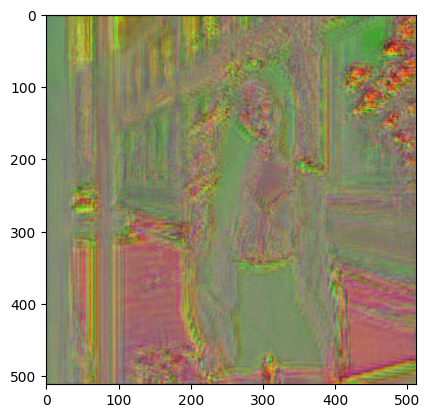

After 20 iters:
Total loss:  8218.259765625
Content loss:  1.3967351913452148
local loss:  0.84716796875
dir loss:  0.76953125
TV loss:  0.007038676179945469


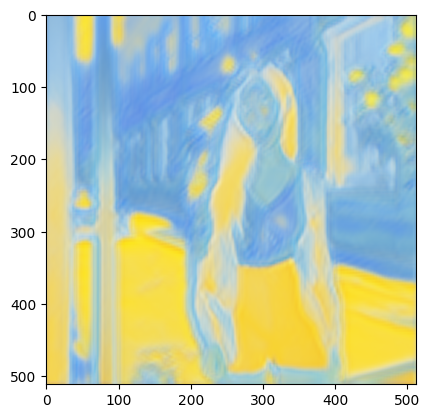

After 40 iters:
Total loss:  7935.4794921875
Content loss:  1.4065282344818115
local loss:  0.81884765625
dir loss:  0.712890625
TV loss:  0.010885857045650482


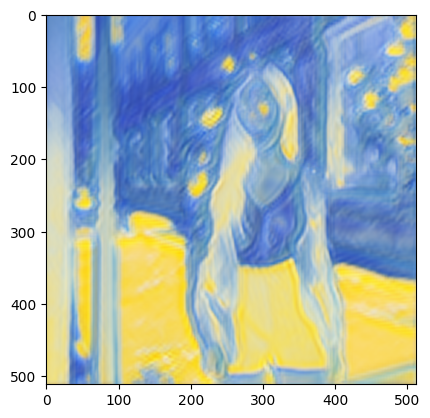

After 60 iters:
Total loss:  7734.3515625
Content loss:  1.4473426342010498
local loss:  0.796875
dir loss:  0.6904296875
TV loss:  0.016273926943540573


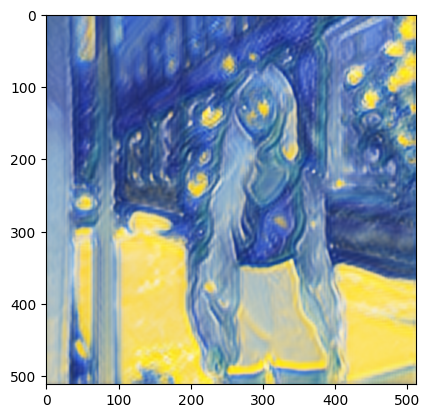

After 80 iters:
Total loss:  7453.95751953125
Content loss:  1.4580512046813965
local loss:  0.767578125
dir loss:  0.654296875
TV loss:  0.020273108035326004


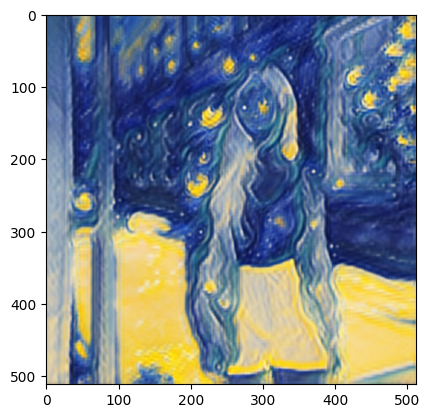

After 100 iters:
Total loss:  7296.09375
Content loss:  1.3972911834716797
local loss:  0.7529296875
dir loss:  0.62109375
TV loss:  0.02506338804960251


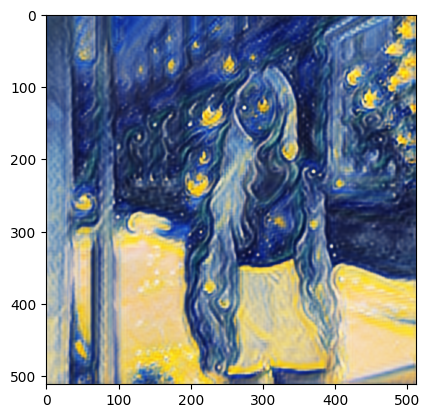

<Figure size 640x480 with 0 Axes>

In [12]:
for epoch in range(0, steps+1):

    optimizer.zero_grad()

    target = style_net(content_image,use_sigmoid=True).to(device)
    target.requires_grad_(True)
    target_features = NST_VGG_model(prepocessing(target))

    loss, cl, loss_glob, loss_local, loss_tv = total_loss(target_features,
                                                          content_features,
                                                          num_crops,
                                                          target,
                                                          source_features,
                                                          text_features,
                                                          text_source,
                                                          threshold = 0.7,
                                                          lambda_content = 150,
                                                          lambda_dir     = 500,
                                                          lambda_local   = 9000,
                                                          lambda_tv      = 2e-3 )

    total_loss_epoch.append(loss)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 20 == 0:
        print("After %d iters:" % epoch)
        print('Total loss: ', loss.item())
        print('Content loss: ', cl.item())
        print('local loss: ', loss_local.item())
        print('dir loss: ', loss_glob.item())
        print('TV loss: ', loss_tv.item())

    if epoch %20 ==0:

        output_image = target.clone()
        output_image = output_image.to('cpu')
        output_image = output_image[0].clamp(0,1).permute(1,2,0).detach().numpy()
        plt.imshow(output_image)
        plt.show()

plt.savefig("out.png")